In [3]:
### Import & setup
import os
import sys
sys.path.append('C:\\Users\\szb37\\My Drive\\Projects\\ADAPT\\ADAPT codebase\\')
import src.folders as folders
import src.power as power
import src.config as config
import pandas as pd
import numpy as np
from statsmodels.stats.proportion import proportion_confint
import src.config as config
from itertools import product
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.dpi'] = 300  # Set display DPI
plt.style.use('seaborn-v0_8-notebook')  # notebook-optimized

def save_fig(fig, fname, dir_out=folders.powerplots):
    for fileformat in ['png', 'svg']:
        fig.savefig(
            fname=os.path.join(dir_out, f'{fname}.{fileformat}'),
            bbox_inches='tight',
            format=fileformat,
            dpi=300,)

### Parameters
prefix = 'mock'
n_trials = 200
sample = 200
samples = np.arange(20, 50, 10).tolist() + np.arange(50, 250, 50).tolist()

# CGR CI vs unmasking power

In [17]:
### Generate CGR data with varying CI

### Masked trials
scenarios = []
df_patientsData = []
scenarios.append(('Masked (CGR=0.5) small CI (±0.01)', (0.49, 0.51))) # ±0.01
scenarios.append(('Masked (CGR=0.5) medium CI (±0.1)', (0.40, 0.60))) # ±0.1
scenarios.append(('Masked (CGR=0.5) large CI (±0.3)',  (0.20, 0.80))) # ±0.3
for scenario in scenarios:
    scenario_name = scenario[0]
    ciL = round(scenario[1][0], 3)
    ciH = round(scenario[1][1], 3)
    
    for tID in np.arange(0, n_trials, 1):

        cgr = np.random.uniform(low=ciL, high=ciH)
        df = power.DataGeneration.get_df_patientsData(
            scenario = f'{scenario_name}', 
            n_trials = 1, 
            sample = sample, 
            params = [{
            'type': 'binaryguess',
            'arm_params':{
                'C': {'cgr': cgr},
                'T': {'cgr': cgr},},}])

        df['trial'] = tID 
        df_patientsData.append(df)
df_patientsData = pd.concat(df_patientsData, ignore_index=True)
df_masked_cgrCIs = power.Stats.get_df_cgrCIs_vector(
    df_patientsData = df_patientsData, 
    samples = samples)
df_masked_cgrCIs = power.Stats.add_sigdiff(df_masked_cgrCIs)
df_masked_cgrCIs.head(3)

### Unmasked trials
scenarios = []
df_patientsData = []
scenarios.append(('Unmasked (CGR=0.65) small CI (±0.01)', (0.64, 0.66))) # ±0.01
scenarios.append(('Unmasked (CGR=0.65) medium CI (±0.1)', (0.55, 0.75))) # ±0.1
scenarios.append(('Unmasked (CGR=0.65) large CI (±0.3)',  (0.35, 0.95))) # ±0.3
for scenario in scenarios:
    scenario_name = scenario[0]
    ciL = round(scenario[1][0], 3)
    ciH = round(scenario[1][1], 3)
    
    for tID in np.arange(0, n_trials, 1):

        cgr = np.random.uniform(low=ciL, high=ciH)
        df = power.DataGeneration.get_df_patientsData(
            scenario = f'{scenario_name}', 
            n_trials = 1, 
            sample = sample, 
            params = [{
            'type': 'binaryguess',
            'arm_params':{
                'C': {'cgr': cgr},
                'T': {'cgr': cgr},},}])

        df['trial'] = tID 
        df_patientsData.append(df)
df_patientsData = pd.concat(df_patientsData, ignore_index=True)
df_unmasked_cgrCIs = power.Stats.get_df_cgrCIs_vector(
    df_patientsData = df_patientsData, 
    samples = samples)
df_unmasked_cgrCIs = power.Stats.add_sigdiff(df_unmasked_cgrCIs)
df_unmasked_cgrCIs.head(3)

,scenario,trial,sample,cgr,cgr_ciL,cgr_ciH,cgr_moe,cgr_sigdiff
0,Unmasked (CGR=0.65) large CI (±0.3),0,20,0.800,0.563,0.943,0.190,True
1,Unmasked (CGR=0.65) large CI (±0.3),0,30,0.867,0.693,0.962,0.135,True
2,Unmasked (CGR=0.65) large CI (±0.3),0,40,0.900,0.763,0.972,0.104,True


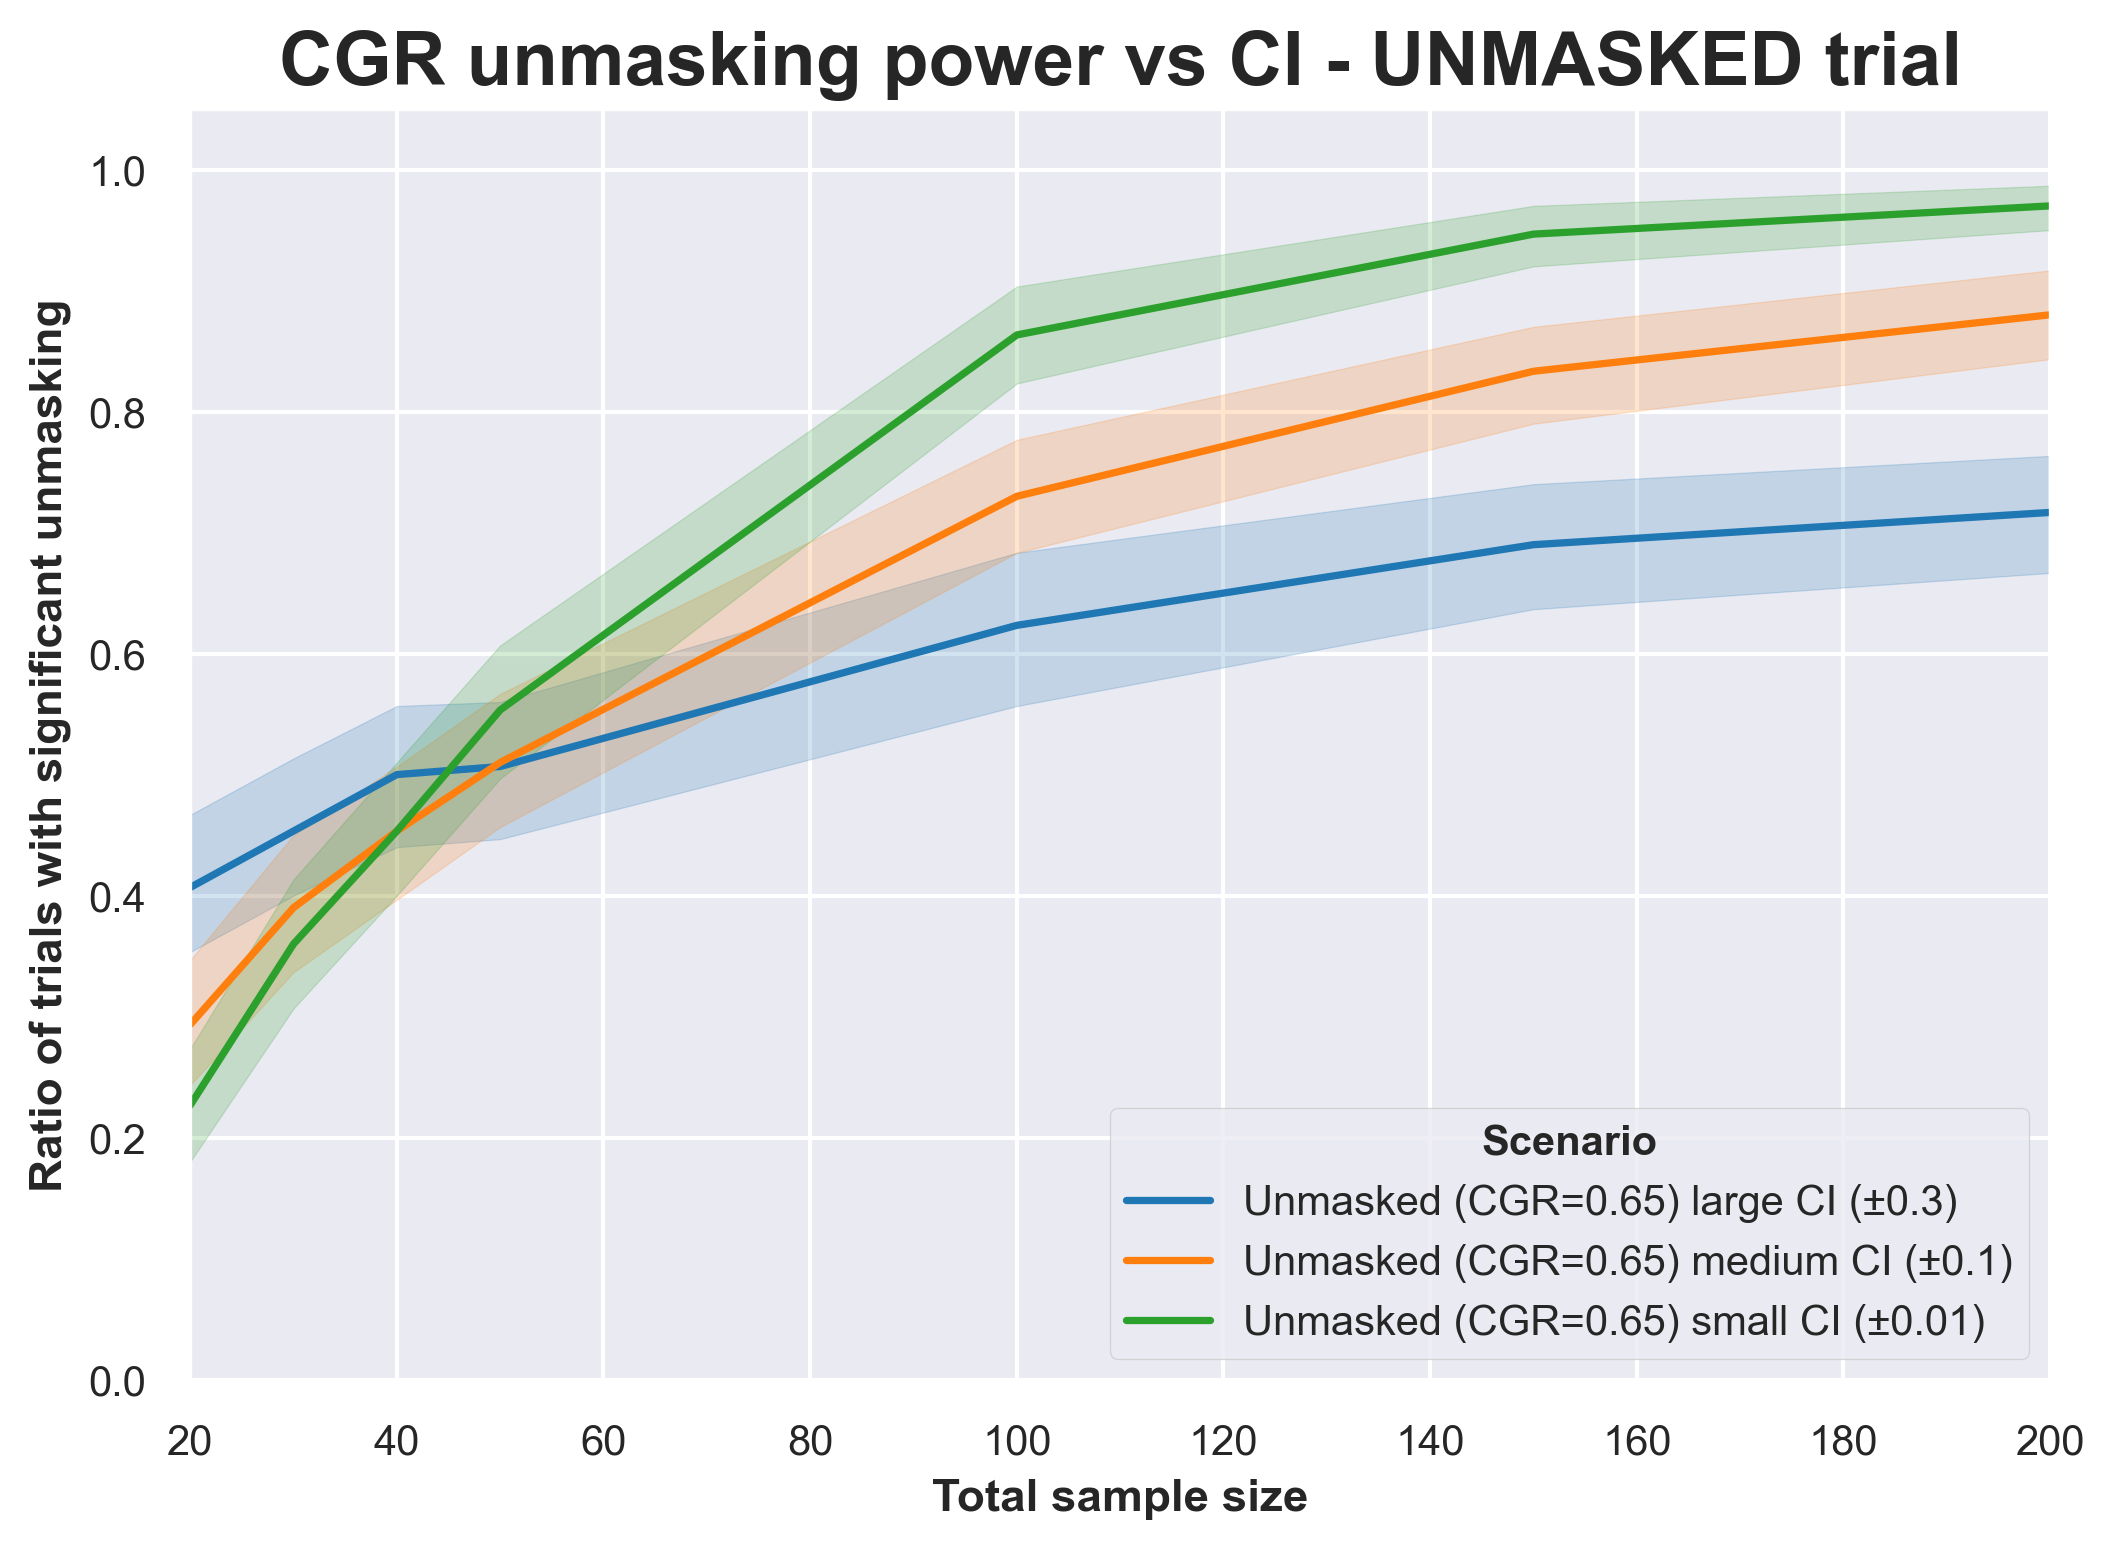

In [18]:
### CGR unmasking power vs CI plot - UNMASKED trial
fig, ax = plt.subplots()
sns.lineplot(
    data = df_unmasked_cgrCIs,
    x = 'sample', 
    y = 'cgr_sigdiff',
    hue = 'scenario',)

plt.title('CGR unmasking power vs CI - UNMASKED trial', fontweight='bold', fontsize=18)
ax.set_xlabel('Total sample size', fontweight='bold')
ax.set_ylabel('Ratio of trials with significant unmasking', fontweight='bold')
ax.set_xlim([df_unmasked_cgrCIs['sample'].min(), df_unmasked_cgrCIs['sample'].max()])
ax.set_ylim([0, 1.05])
plt.legend(
    title='Scenario', 
    title_fontproperties = {'weight': 'bold'},)
plt.show()
save_fig(fig, fname='unmasking_power_cgr_vs_CI_unmaskedTrial')

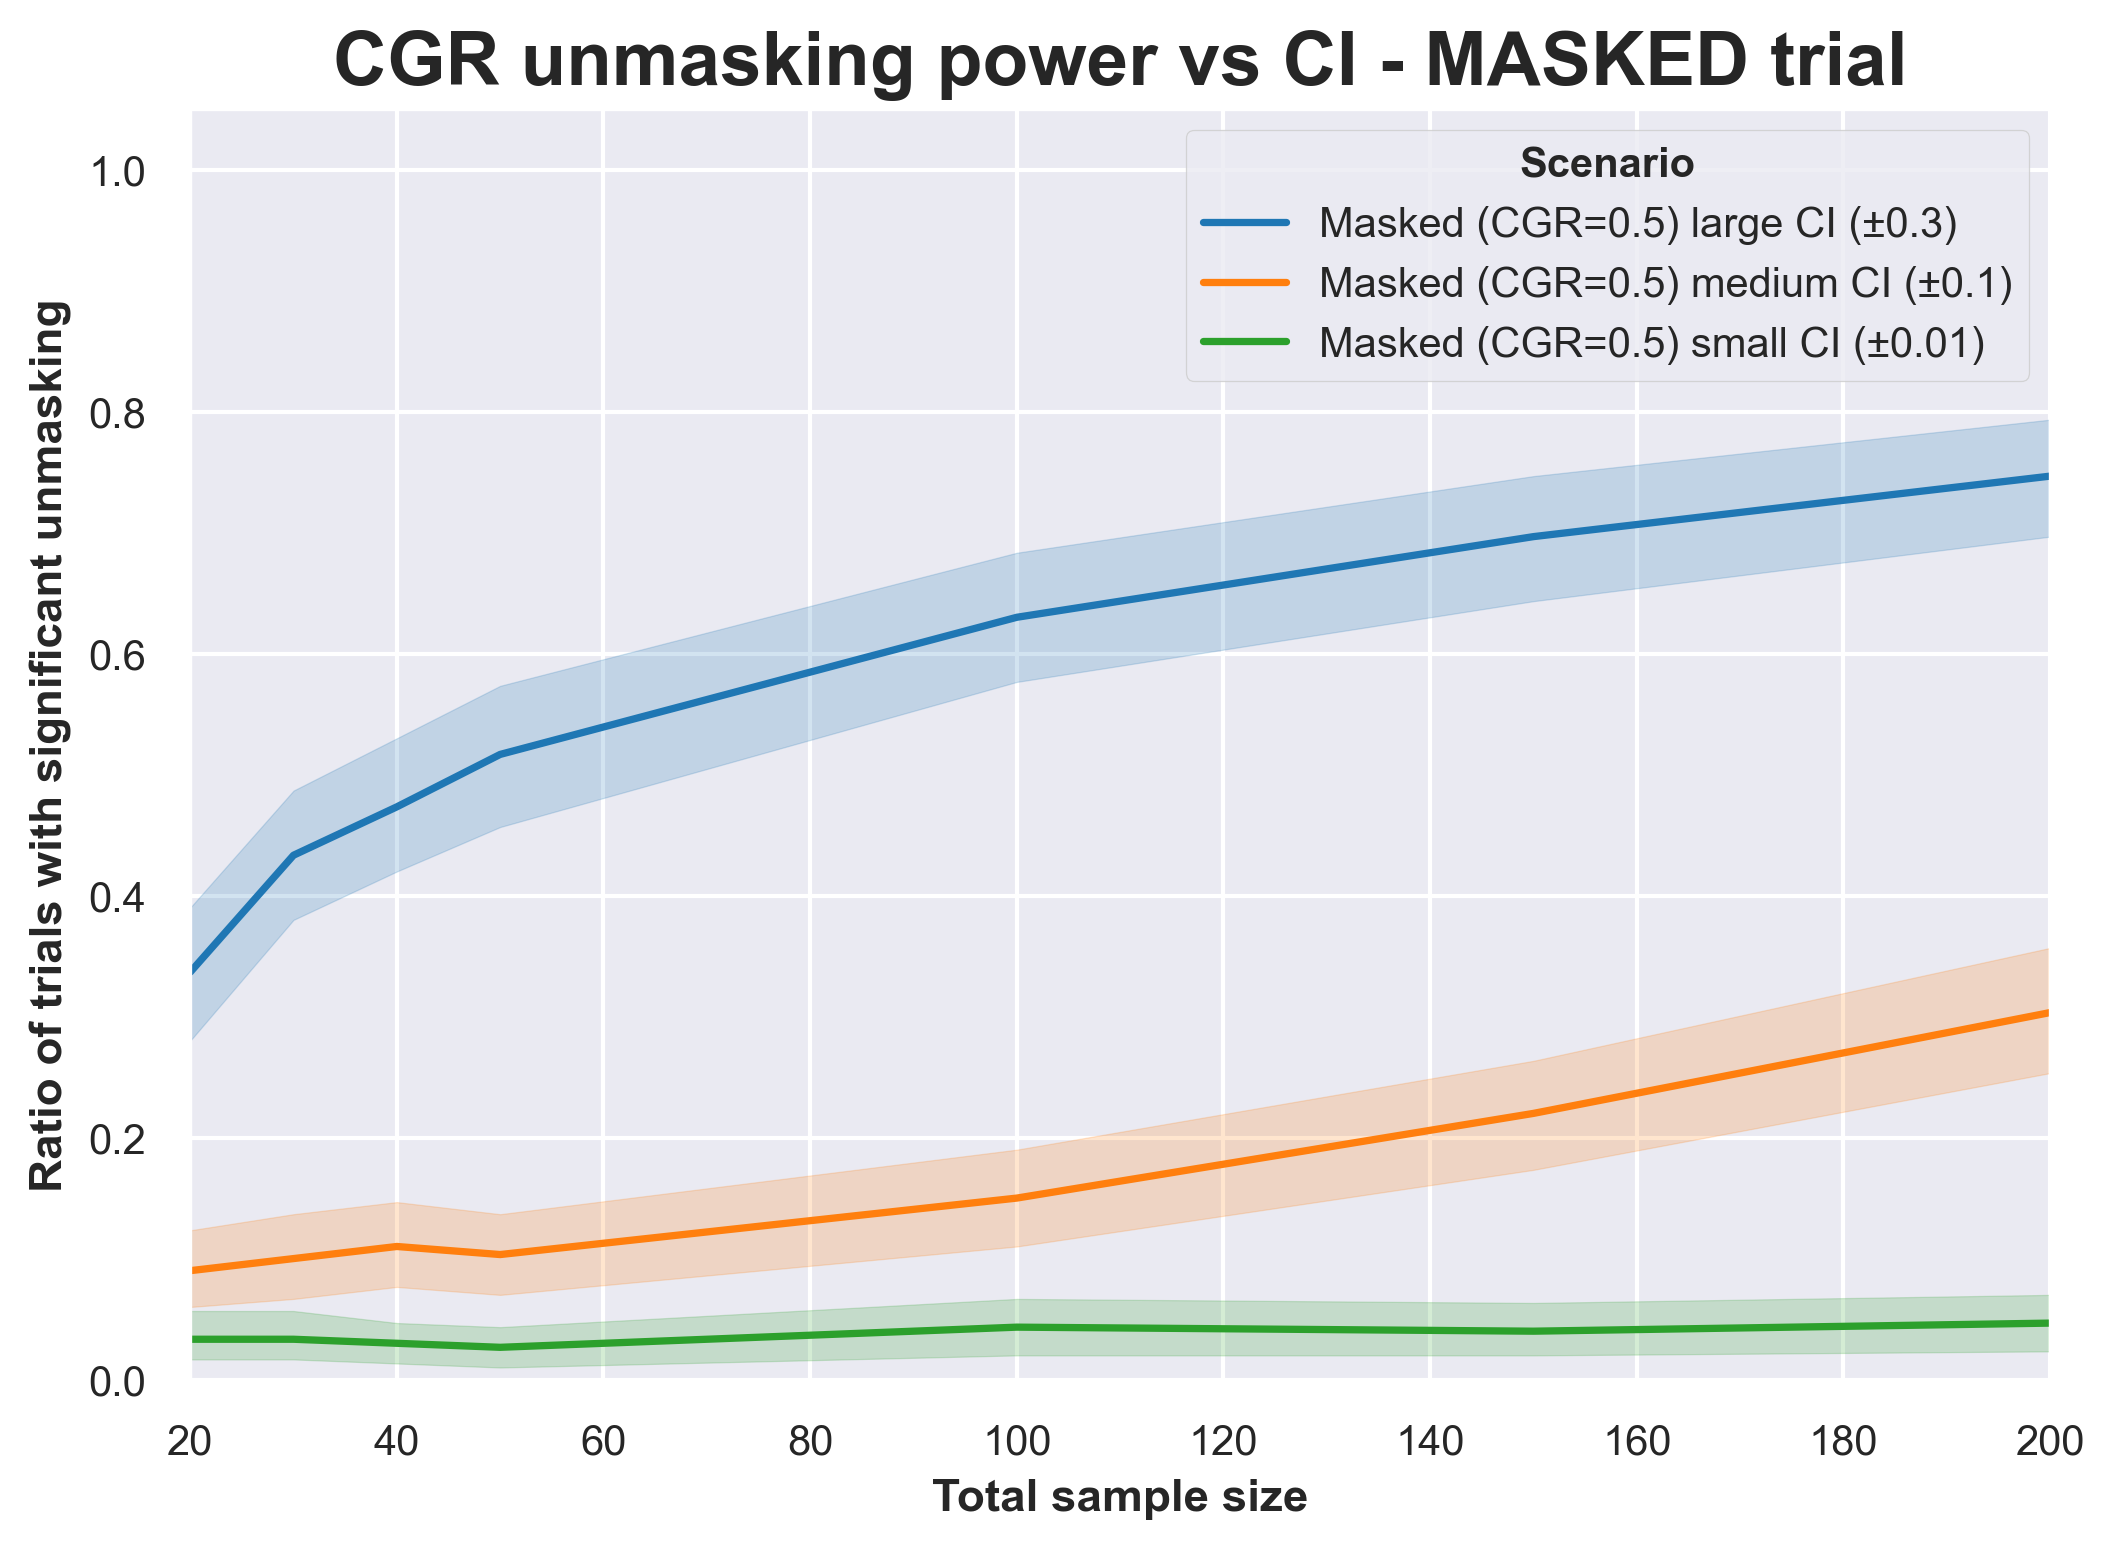

In [19]:
### CGR unmasking power vs CI plot - MASKED trial
fig, ax = plt.subplots()
sns.lineplot(
    data = df_masked_cgrCIs,
    x = 'sample', 
    y = 'cgr_sigdiff',
    hue = 'scenario',)

plt.title('CGR unmasking power vs CI - MASKED trial', fontweight='bold', fontsize=18)
ax.set_xlabel('Total sample size', fontweight='bold')
ax.set_ylabel('Ratio of trials with significant unmasking', fontweight='bold')
ax.set_xlim([df_masked_cgrCIs['sample'].min(), df_masked_cgrCIs['sample'].max()]) # df_outcomeCIs['sample'].max()])
ax.set_ylim([0, 1.05])
plt.legend(
    title='Scenario', 
    title_fontproperties = {'weight': 'bold'},)
plt.show()
save_fig(fig, fname='unmasking_power_cgr_vs_CI_maskedTrial')

# GMG CI vs unmasking power

## Unmasked trial

In [20]:
### Define combined gmgs
rows=[]

### Small CI
row={}
row['scenario']='Unmasked (Δguess=4mg) small CI (±3mg)'
row['trt']='C'
row['gmg']=10
row['gmg_ciL']=7
row['gmg_ciH']=13
rows.append(row)
row={}
row['scenario']='Unmasked (Δguess=4mg) small CI (±3mg)'
row['trt']='T'
row['gmg']=13
row['gmg_ciL']=10
row['gmg_ciH']=16
rows.append(row)

### Mid CI
row={}
row['scenario']='Unmasked (Δguess=4mg) mid CI (±6mg)'
row['trt']='C'
row['gmg']=10
row['gmg_ciL']=4
row['gmg_ciH']=16
rows.append(row)
row={}
row['scenario']='Unmasked (Δguess=4mg) mid CI (±6mg)'
row['trt']='T'
row['gmg']=13
row['gmg_ciL']=7
row['gmg_ciH']=19
rows.append(row)

### Large CI
row={}
row['scenario']='Unmasked (Δguess=4mg) large CI (±9mg)'
row['trt']='C'
row['gmg']=10
row['gmg_ciL']=1
row['gmg_ciH']=19
rows.append(row)
row={}
row['scenario']='Unmasked (Δguess=4mg) large CI (±9mg)'
row['trt']='T'
row['gmg']=13
row['gmg_ciL']=4
row['gmg_ciH']=22
rows.append(row)

df_combined_gmgs=pd.DataFrame(rows)
#df_combined_gmgs

In [ ]:
### Generate GMG data by sampling from CI 

rows = []
for scenario in df_combined_gmgs.scenario.unique():
    for tID, pID in product(np.arange(0, n_trials, 1), np.arange(0, sample, 1)):
        
        trt = np.random.choice(['C', 'T'], size=1)
        trt = str(trt[0])

        ciL = df_combined_gmgs.loc[
            (df_combined_gmgs.scenario==scenario) & 
            (df_combined_gmgs.trt==trt), 'gmg_ciL'].values[0]

        ciH = df_combined_gmgs.loc[
            (df_combined_gmgs.scenario==scenario) & 
            (df_combined_gmgs.trt==trt), 'gmg_ciH'].values[0]

        row = {}
        row['scenario'] = scenario
        row['trial'] = tID
        row['trt'] = trt
        row['pID'] = pID
        row['gmg'] = round(np.random.uniform(low=ciL, high=ciH), 1)
        rows.append(row)
df_patientsData = pd.DataFrame(rows)

### Calculate GMG CIs
df_gmgCIs = power.Stats.get_df_diffCIs_vector(
    df_patientsData = df_patientsData, 
    samples = samples,
    col='gmg',) 
df_gmgCIs = power.Stats.add_sigdiff(df_gmgCIs)
#df_gmgCIs.head(3)

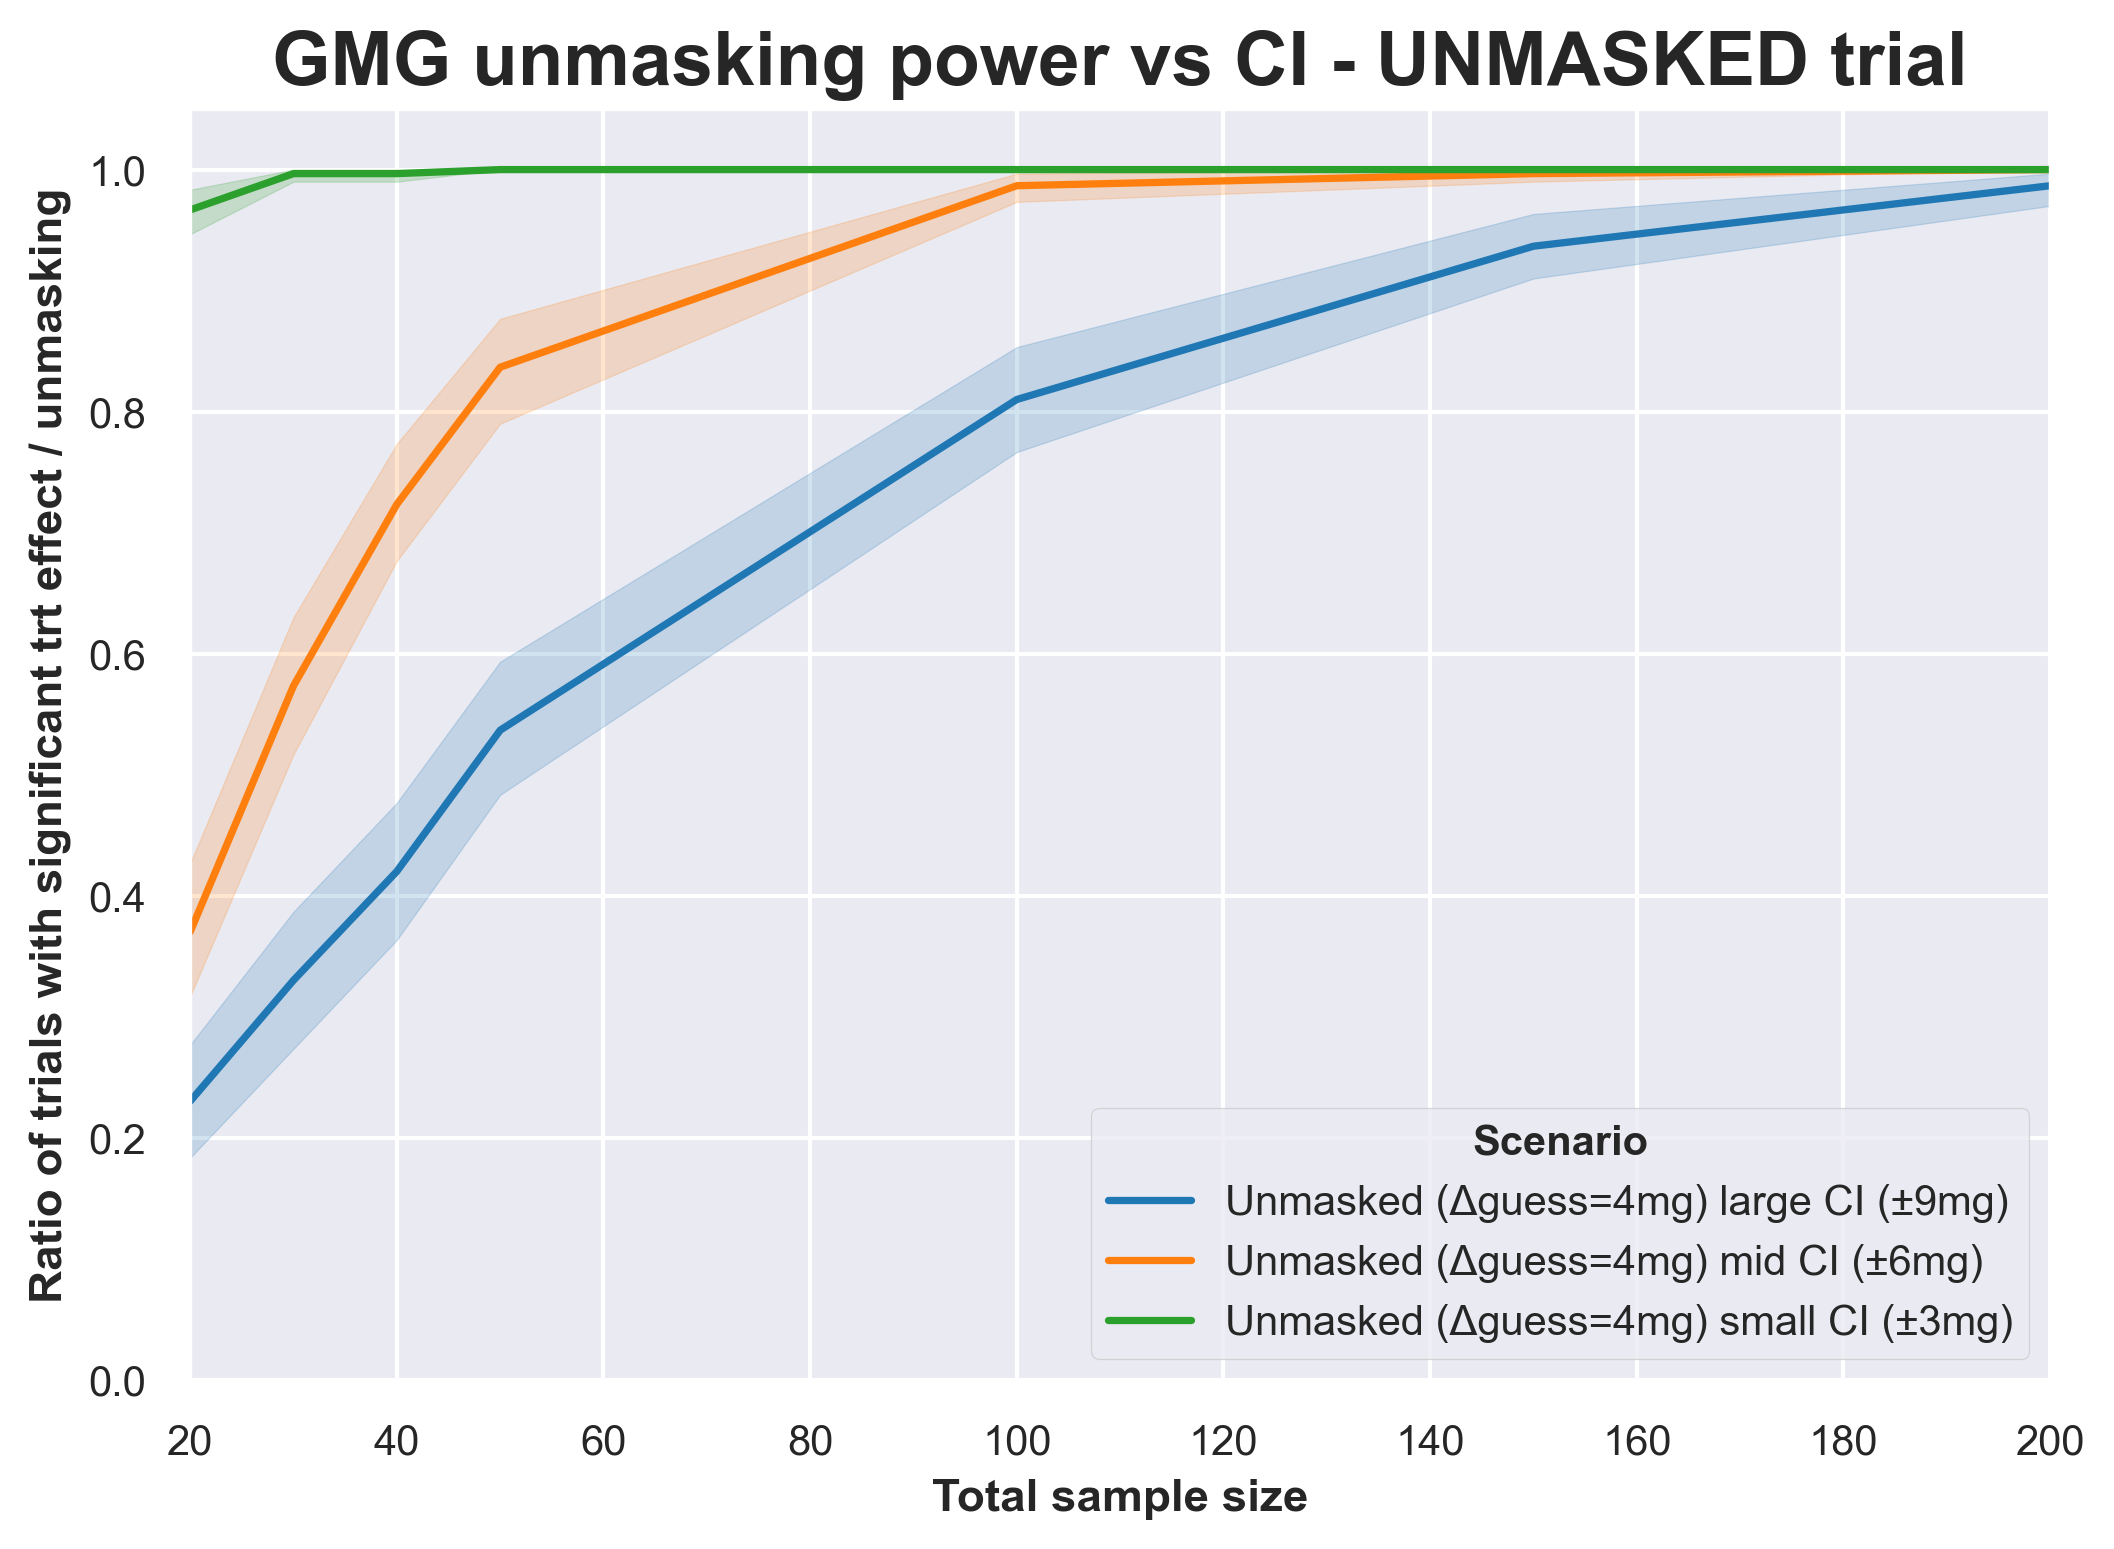

In [22]:
### GMG unmasking power vs CI plot - UNMASKED trial
fig, ax = plt.subplots()
sns.lineplot(
    data = df_gmgCIs,
    x = 'sample', 
    y = 'gmg_sigdiff',
    hue = 'scenario',)

plt.title('GMG unmasking power vs CI - UNMASKED trial', fontweight='bold', fontsize=18)
ax.set_xlabel('Total sample size', fontweight='bold')
ax.set_ylabel('Ratio of trials with significant trt effect / unmasking', fontweight='bold')
ax.set_xlim([df_gmgCIs['sample'].min(), df_gmgCIs['sample'].max()])
ax.set_ylim([0, 1.05])
plt.legend(
    title='Scenario', 
    title_fontproperties = {'weight': 'bold'},
    loc='lower right')
plt.show()
save_fig(fig, fname='unmasking_power_gmg_vs_CI_unmaskedTrial')

## Masked trial

In [4]:
### Define combined gmgs
rows=[]

### Small CI
row={}
row['scenario']='Masked (Δguess=0mg) small CI (±1mg)'
row['trt']='C'
row['gmg']=15
row['gmg_ciL']=14
row['gmg_ciH']=16
rows.append(row)
row={}
row['scenario']='Masked (Δguess=0mg) small CI (±1mg)'
row['trt']='T'
row['gmg']=15
row['gmg_ciL']=14
row['gmg_ciH']=16
rows.append(row)

# ### Mid CI
# row={}
# row['scenario']='Masked (Δguess=0mg) mid CI (±6mg)'
# row['trt']='C'
# row['gmg']=10
# row['gmg_ciL']=4
# row['gmg_ciH']=16
# rows.append(row)
# row={}
# row['scenario']='Masked (Δguess=0mg) mid CI (±6mg)'
# row['trt']='T'
# row['gmg']=10
# row['gmg_ciL']=4
# row['gmg_ciH']=16
# rows.append(row)

### Large CI
row={}
row['scenario']='Masked (Δguess=0mg) large CI (±15mg)'
row['trt']='C'
row['gmg']=15
row['gmg_ciL']=0
row['gmg_ciH']=30
rows.append(row)
row={}
row['scenario']='Masked (Δguess=0mg) large CI (±15mg)'
row['trt']='T'
row['gmg']=15
row['gmg_ciL']=0
row['gmg_ciH']=30
rows.append(row)

df_combined_gmgs=pd.DataFrame(rows)
df_combined_gmgs

,scenario,trt,gmg,gmg_ciL,gmg_ciH
0,Masked (Δguess=0mg) small CI (±1mg),C,15,14,16
1,Masked (Δguess=0mg) small CI (±1mg),T,15,14,16
2,Masked (Δguess=0mg) large CI (±15mg),C,15,0,30
3,Masked (Δguess=0mg) large CI (±15mg),T,15,0,30


In [ ]:
### Generate GMG data with varying CI
# n_trials=50
# sample=50

rows = []
for scenario in df_combined_gmgs.scenario.unique():
    for tID, pID in product(np.arange(0, n_trials, 1), np.arange(0, sample, 1)):
        
        trt = np.random.choice(['C', 'T'], size=1)
        trt = str(trt[0])

        ciL = df_combined_gmgs.loc[
            (df_combined_gmgs.scenario==scenario) & 
            (df_combined_gmgs.trt==trt), 'gmg_ciL'].values[0]

        ciH = df_combined_gmgs.loc[
            (df_combined_gmgs.scenario==scenario) & 
            (df_combined_gmgs.trt==trt), 'gmg_ciH'].values[0]

        row = {}
        row['scenario'] = scenario
        row['trial'] = tID
        row['trt'] = trt
        row['pID'] = pID
        row['gmg'] = round(np.random.uniform(low=ciL, high=ciH), 1)
        rows.append(row)
df_patientsData = pd.DataFrame(rows)

### Calculate GMG CIs
df_gmgCIs = power.Stats.get_df_diffCIs_vector(
    df_patientsData = df_patientsData, 
    samples = samples,
    col='gmg',) 
df_gmgCIs = power.Stats.add_sigdiff(df_gmgCIs)
df_gmgCIs.head(3)

,scenario,trial,sample,gmg_diff,gmg_ciL,gmg_ciH,gmg_moe,gmg_sigdiff
0,Masked (Δguess=0mg) large CI (±15mg),0,20,4.850,-4.510,14.210,9.360,False
1,Masked (Δguess=0mg) large CI (±15mg),0,30,3.548,-3.638,10.733,7.185,False
2,Masked (Δguess=0mg) large CI (±15mg),0,40,2.896,-3.094,8.887,5.991,False


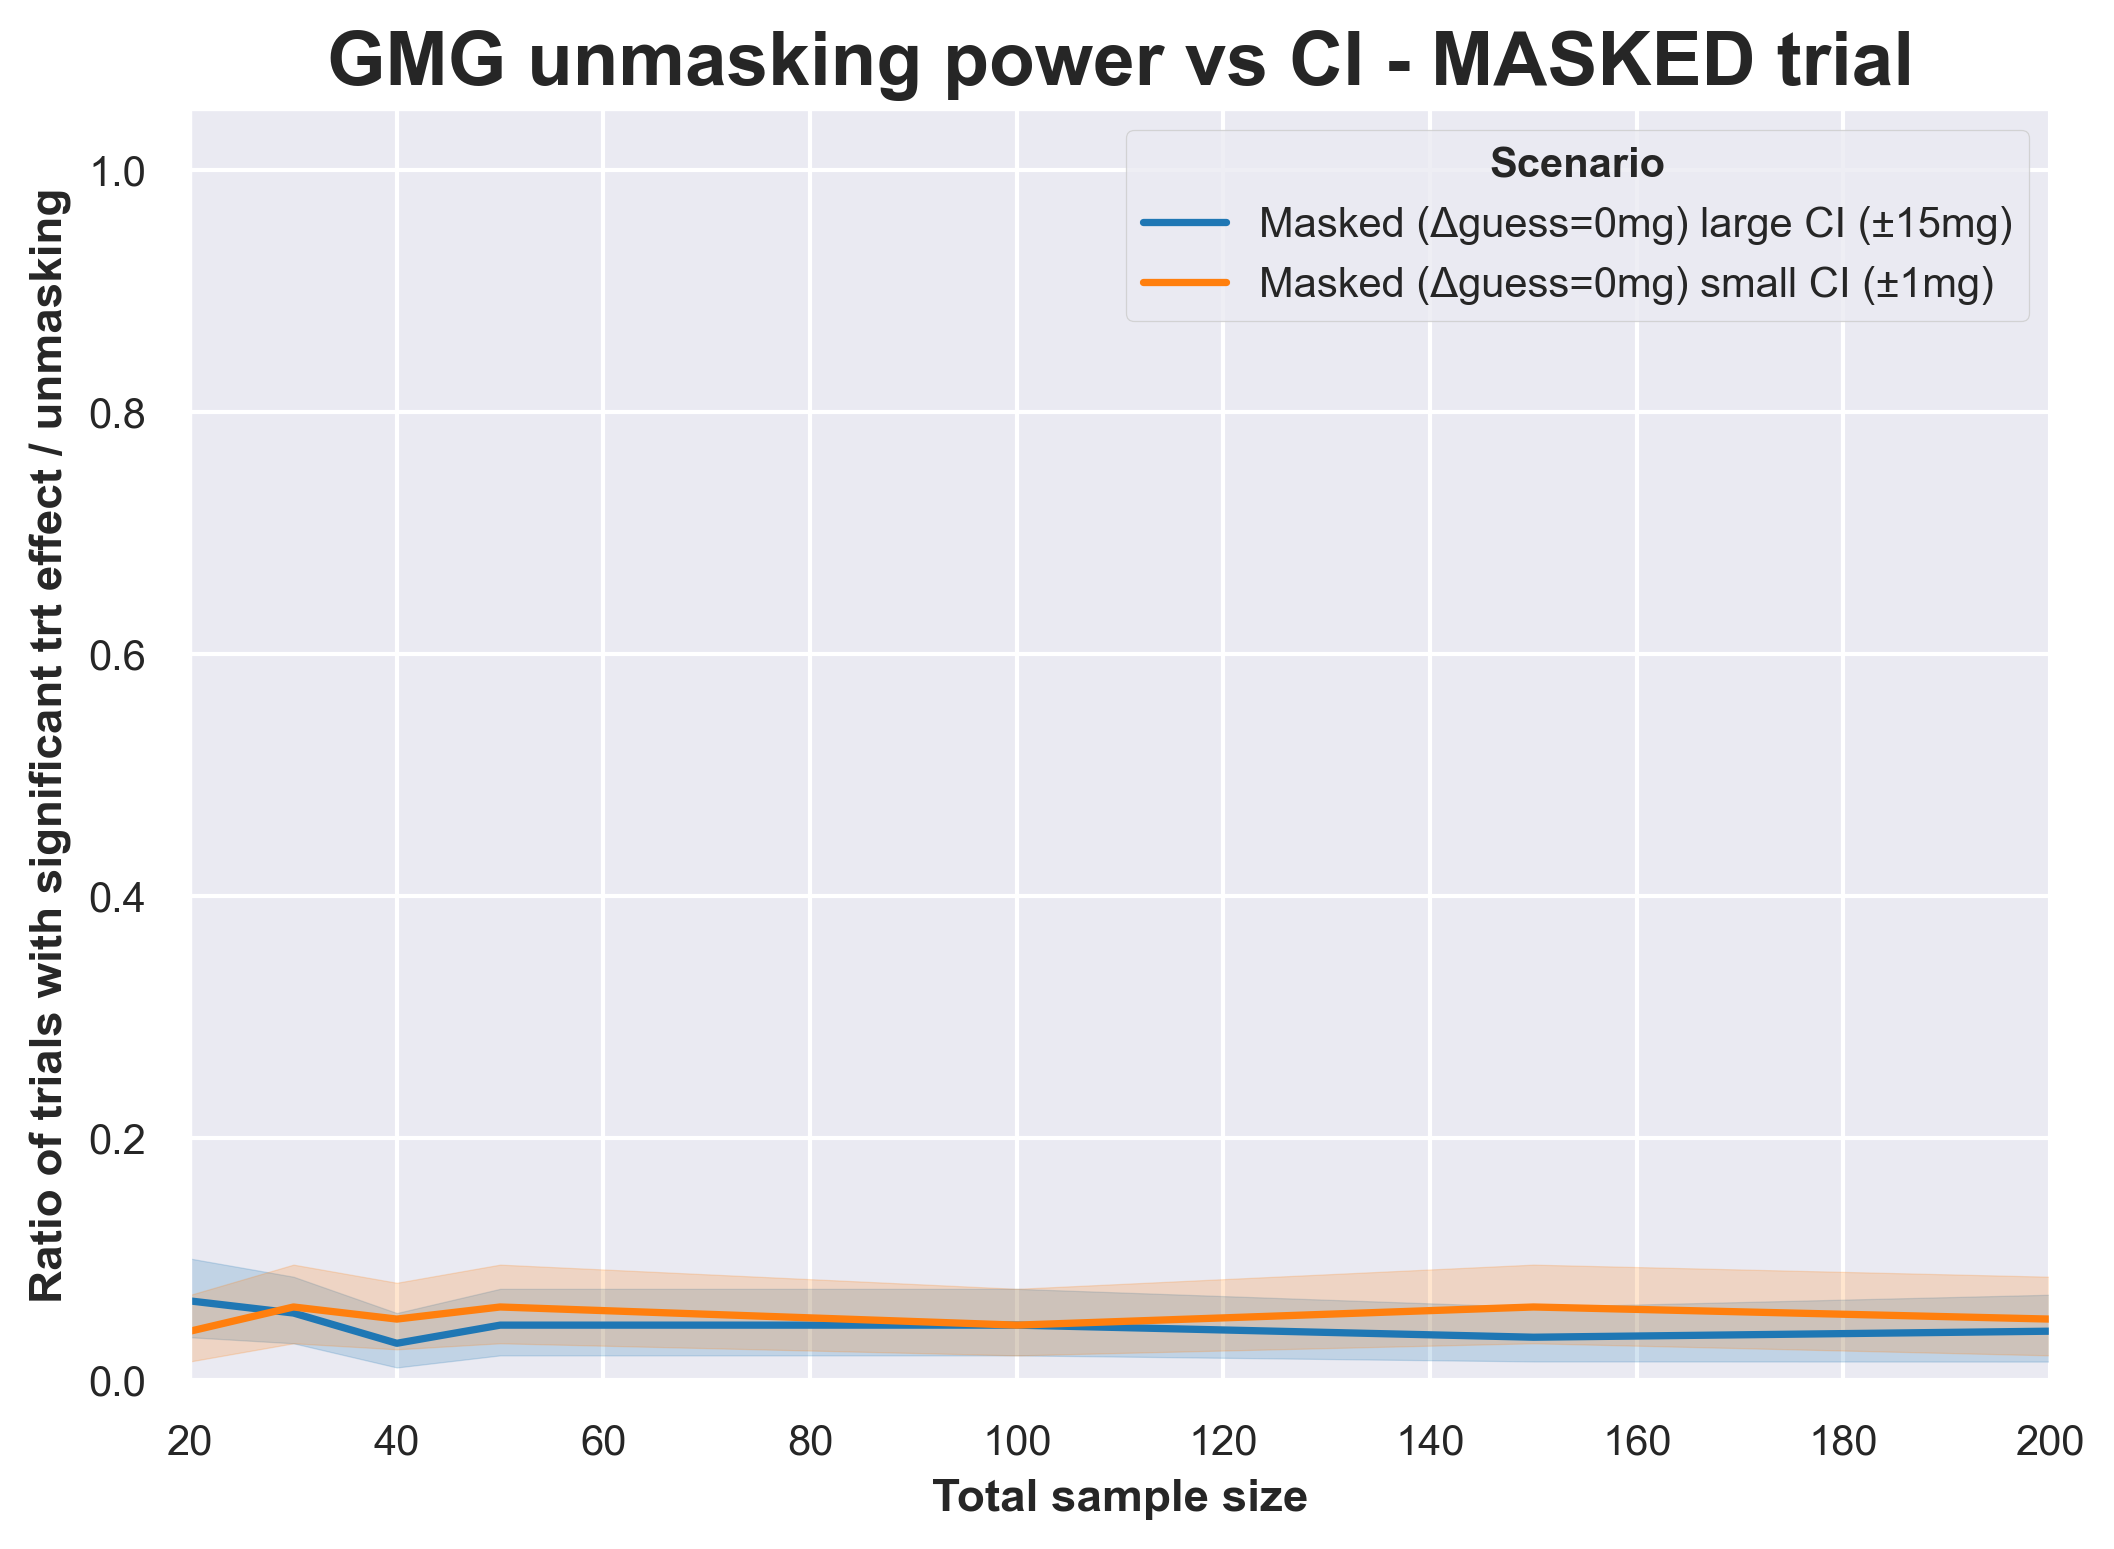

In [7]:
### GMG unmasking power vs CI plot - MASKED trial
fig, ax = plt.subplots()
sns.lineplot(
    data = df_gmgCIs,
    x = 'sample', 
    y = 'gmg_sigdiff',
    hue = 'scenario',)

plt.title('GMG unmasking power vs CI - MASKED trial', fontweight='bold', fontsize=18)
ax.set_xlabel('Total sample size', fontweight='bold')
ax.set_ylabel('Ratio of trials with significant trt effect / unmasking', fontweight='bold')
ax.set_xlim([df_gmgCIs['sample'].min(), df_gmgCIs['sample'].max()])
ax.set_ylim([0, 1.05])
plt.legend(
    title='Scenario', 
    title_fontproperties = {'weight': 'bold'},)
plt.show()
save_fig(fig, fname='unmasking_power_gmg_vs_CI_maskedTrial')